---

## 12.3 Neural style transfer

In [1]:
import os, sys, pathlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo

import tensorflow as tf

In [4]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive') # 'My Drive' is the default name of Google Drives,
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/8-generative-deep-learning') 
    os.listdir() 

The aim is to apply the *style* of one image to the *content* of another image.

- **Style**: textures, colours, visual patterns;
- **Content**: high level macrostructure.

#### van Gogh-like brushstrokes applied to a photograph

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

<small>DLWP, p.383</small>

What we want is to **define a loss fuction** for what we wish to achieve and then minimise it.

In our case, we want:

```python
loss = (
    # 1. minimise the distance in style between two images
    distance(style(reference_image), style(generated_image))
    +
    # 2. minimise the distance in content between two images
    distance(content(original_image), content(generated_image))
)
```

The overall process will be:

1. We pass our content image and our style image to a **pretrained network**;
2. We will look at how our network reacts to both images:
    - in terms of content (content loss) and
    - in terms of style (style loss);
3. We will **learn the image**:  
    i.e. take the gradient of the combined loss and see how to change the image to lower it;
3. through the loss, we will enforce:
    - that the **content** are as close to the content image, and;
    - that the **style** are as close to the style image, as posssible.

---

### 12.3.1 The content loss


We know that upper layers contain more *global* information – **macrostructure** or **content**.

We will compare the **activations** of the upper layer(s) of a pretrained ConvNet.

We pass both content and style image, and we look at the **same activation layers** for both.

The loss used to compare them is the **squared distance**.


---

### 12.3.2 The style loss

The aim is to capture the appearance of the target image at all spatial scales.

Style loss aims to preserve the **correlations** between activations of different layers.

The idea is that textures are represented as correlations at different scales.

---

### The variation loss

There also one final loss, which tries to keep in check the local variation of pixels in the generated image (works like a regulariser).

We shift the pixels by 1 in the width and in the height, add those (in effect: neighbours) and look at the total difference that this produces (we reduce that, forcing neighbours to be similar to each other).

---

### 12.3.3 Neural style transfer in Keras

1. Use a pretrained convnet e.g. **VGG19** (VGG16 + 3 extra conv. layers);
2. Compute the layer activations for the style-reference image, the original image and the generated image;
3. Minimise the loss with gradient descent.

**Getting the style and content images**

In [5]:
basedir = pathlib.Path("neural-style-transfer")
if not basedir.is_dir():
    os.mkdir(basedir)
    
base_image_path = tf.keras.utils.get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg",
    cache_dir=basedir,
    cache_subdir="",
)
style_reference_image_path = tf.keras.utils.get_file(
    "starry_nqght.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg",
    cache_dir=basedir,
    cache_subdir="",
)

original_width, original_height = tf.keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

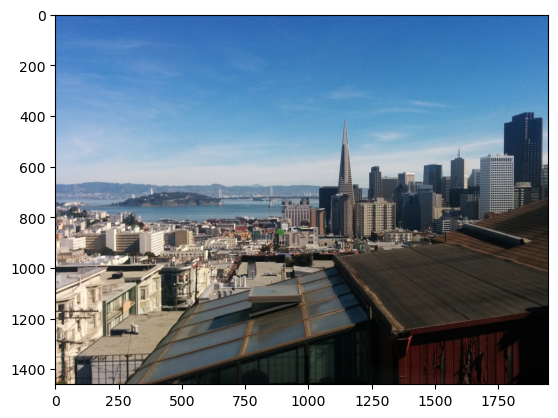

In [6]:
plt.imshow(tf.keras.utils.load_img(base_image_path))

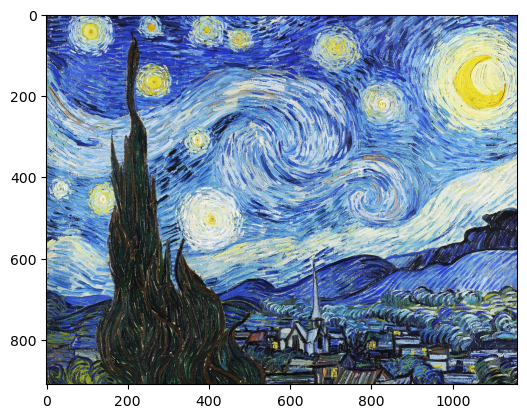

In [7]:
plt.imshow(tf.keras.utils.load_img(style_reference_image_path))

**Auxiliary functions**

In [8]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(                          # load image, specifying the size
        image_path, target_size=(img_height, img_width)
    )
    img = tf.keras.utils.img_to_array(img)                  # to array
    img = np.expand_dims(img, axis=0)                       # add batch dim
    img = tf.keras.applications.vgg19.preprocess_input(img) # specific VGG19 preprocessing
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                       # vgg19.preprocess_input zero centers data by
    img[:, :, 1] += 116.779                       # removing the mean channel value from ImageNet:
    img[:, :, 2] += 123.68                        # here, we simply do this process in reverse
    img = img[:, :, ::-1]                         # vgg19.preprocess_input has BGR channels, reversed here to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [9]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Content loss**

In [11]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img)) # squared distance

**Style loss**

In [112]:
def gram_matrix(x):
    """
    Calculate the correlations across channels.
    Returns the Gram Matrix, of shape (c, c):
        the correlation score of every channel with itself and all others.
    """
    x = tf.transpose(x, (2, 0, 1))                     # x from (w, h, c) → (c,w,h), channels first
    features = tf.reshape(x, (tf.shape(x)[0], -1))     # flatten w & h (-1: "calculate that dimension for me")
    gram = tf.matmul(features, tf.transpose(features)) # matmul: channelwise product & sum over all elements
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)        # get the gram matrix (correlations)
    C = gram_matrix(combination_img)  # for both style and combination images
    channels = 3
    size = img_height * img_width
         # ↑ the normalised elementwise squared difference between the correlations of two matrices
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
                                           # ↑ normalisation constant

In [117]:
def gram_matrix_v(x, verbose=False):
    if verbose: 
        print("x shape:         ", x.shape)
    x = tf.transpose(x, (2, 0, 1))
    if verbose: 
        print("x reshaped:      ", x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    if verbose: 
        print("features shape:  ", features.shape)    
        print("transposed shape:", tf.transpose(features).shape)    
    gram = tf.matmul(features, tf.transpose(features))
    if verbose: 
        print("gram shape:      ", gram.shape)   
    return gram

gram_matrix_v(base_image[0], verbose=True)

x shape:          (400, 533, 3)
x reshaped:       (3, 400, 533)
features shape:   (3, 213200)
transposed shape: (213200, 3)
gram shape:       (3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.3302045e+09, 8.5740941e+08, 3.7664624e+08],
       [8.5740941e+08, 7.8420851e+08, 6.7147302e+08],
       [3.7664624e+08, 6.7147302e+08, 9.2326701e+08]], dtype=float32)>

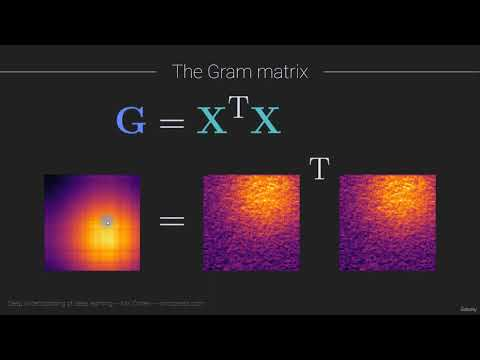

In [2]:
YouTubeVideo('FQiNeuRqZu8', width=853, height=480) # 22.2 The Gram matrix feature activation covariance 

**Total variation loss**

In [13]:
def total_variation_loss(x):
    """
    Operation on the generated image: 'encourages spatial continuity in
    the generated image, thus avoiding overly pixelated results', DLWP, p. 388.
    """
    # variation: horizontal
    a = tf.square( #                                      ↓ shift by one in the width 
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑
    # variation: vertical
    b = tf.square( #                                                        ↓ shift by one in the height
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑
    return tf.reduce_sum(tf.pow(a + b, 1.25)) # where does this number come from?!?

**Defining the final loss that you'll minimize**

In [96]:
                                    # TWEAK ME!
style_layer_names = [               # the style layers
#     "block1_conv1",
#     "block2_conv1",
    "block3_conv1",
    "block4_conv1",
#     "block5_conv1",
]
content_layer_name = "block5_conv2" # the content layer (could be more than one)

total_variation_weight = 1e-8       # total loss weight, Chollet: 1e-6
style_weight = 1.5e-6               # style, Chollet: 1e-6
content_weight = 1e-9               # content, Chollet: 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat( # concatenate our three images
        [base_image, style_reference_image, combination_image], axis=0
    ) # and run then through the network once
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
                                                                             # 1. CONTENT LOSS
    layer_features = features[content_layer_name]                            # extract content features (layers)
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(                             # content loss, weighted
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:                                     # 2. STYLE LOSS
        layer_features = features[layer_name]                                # extract style features (layers)
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(                                       # style loss
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value   # weighting and averaging
                               # ↑ (here all style layers have the same weight, but that could be changed!)
    loss += total_variation_weight * total_variation_loss(combination_image) # 3. VARIATION LOSS
    return loss

**Setting up the gradient-descent process**

Docs for TensorFlow [schedules](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules).

In [102]:
@tf.function # make it fast by compiling the function with @tf.function!
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0,
        decay_steps=100,
        decay_rate=0.96
    )
)

Iteration 100: loss=3826.756

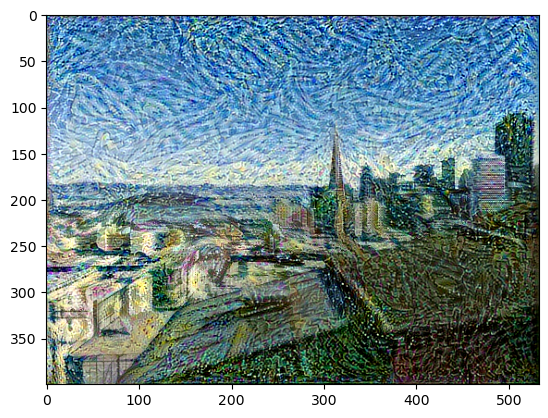

Iteration 200: loss=3348.90

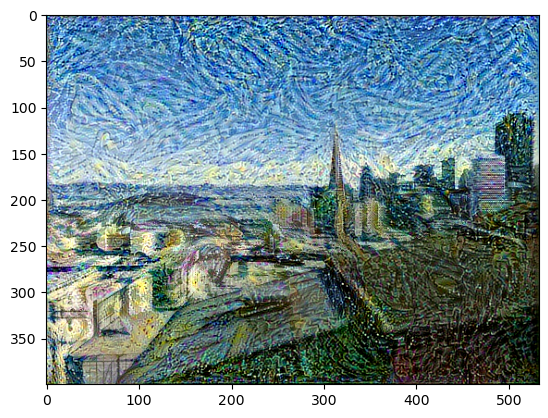

In [103]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 200 # Chollet: 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    print(f"\rIteration {i}: loss={loss:.2f}", end="")
    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = basedir / f"combination_image_at_iteration_{i}.png"
        tf.keras.utils.save_img(fname, img)
        plt.imshow(img)
        plt.show()
    
img = deprocess_image(combination_image.numpy())
fname = basedir / f"combination_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)

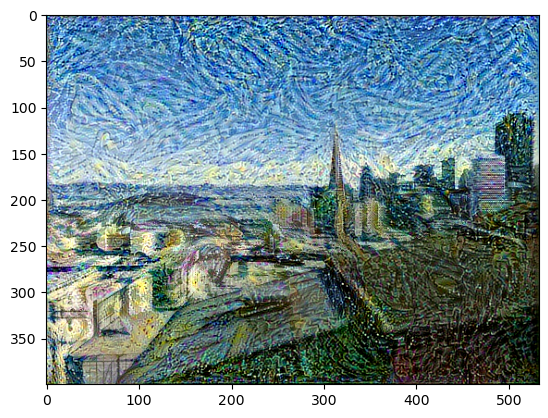

In [104]:
plt.imshow(tf.keras.utils.load_img(fname))

### References

[Gatis et al., "A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576)

Andrew Ng's videos on Neural Style Transfer (as part of [this playlist](https://www.youtube.com/watch?v=R39tWYYKNcI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=37)):

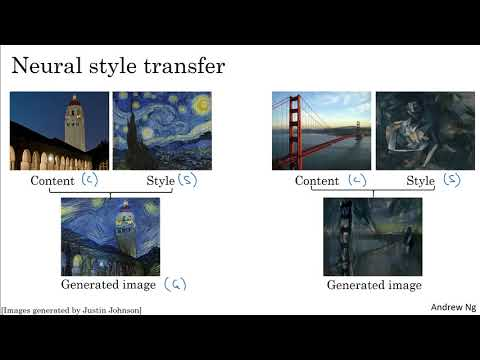

In [51]:
YouTubeVideo('R39tWYYKNcI', width=853, height=480) # Andrew Ng, C4W4L06 What is neural style transfer?

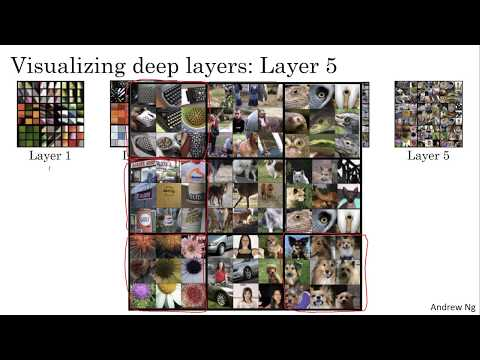

In [3]:
YouTubeVideo('ChoV5h7tw5A', width=853, height=480) # Andrew Ng, C4W4L07 What are deep CNs learning?

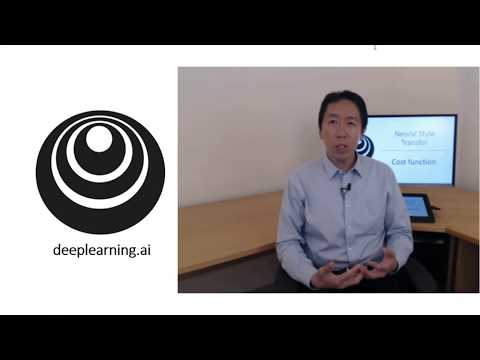

In [5]:
YouTubeVideo('xY-DMAJpIP4', width=853, height=480) # Andrew Ng, C4W4L08 Cost Function

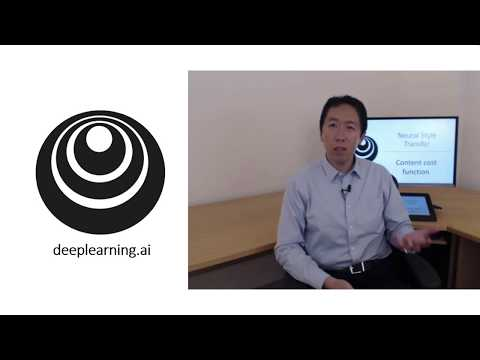

In [6]:
YouTubeVideo('b1I5X3UfEYI', width=853, height=480) # Andrew Ng, C4W4L09 Content Cost Function

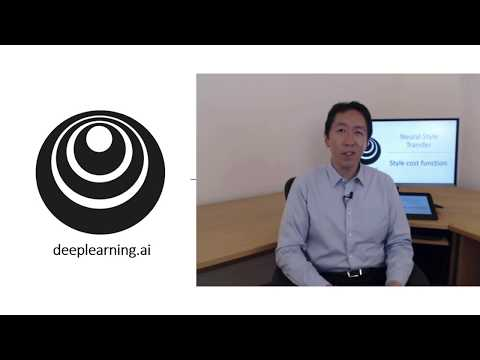

In [7]:
YouTubeVideo('QgkLfjfGul8', width=853, height=480) # Andrew Ng, C4W4L10 Style Cost Function

### Experiments

- Same as with DeepDream, experiment with different **layers** and **hyperparameters**;
- Try it with a different network;
- It might be nice to implement some sort of search of the space for interesting effects and to build intuition.

#### Note

Beware, depending on the values you choose, your overall loss may blow up to infinity (if you see 'nan' in the loss, you've hit it). I haven't implemented safety checks, that could be done, and instead I just tweaked the parameters. 

### 12.2.2 Wrapping up

- Style transfer adorns the contents of a target image with style of a reference image;
- Content can be captured by the **high-level activations** of a convnet;
- Style can be captured by the **internal correlations of the activations** of different layers of a convnet;
- We **learn the combination image** An optimization process with a special loss;
- There are many variants and refinements.